In [1]:
%load_ext autoreload
%autoreload 2

%load_ext scalene

from Optimizer import *
from SlippageModel import average_slippage_model_vectorized, average_slippage_model_cvxpy

import pandas as pd
import numpy as np

import sys
import os

import optuna

# Absolute or relative path to your library
lib_path = os.path.abspath("/home/ubuntu/git/Baus-Research/")

# Add to sys.path
if lib_path not in sys.path:
    sys.path.append(lib_path)

from src.baus_utils.data_utils import get_tardis_files
from src.baus_utils.system_utils import log_message

Scalene extension successfully loaded. Note: Scalene currently only
supports CPU+GPU profiling inside Jupyter notebooks. For full Scalene
profiling, use the command line version. To profile in line mode, use
`%scrun [options] statement`. To profile in cell mode, use `%%scalene
[options]` followed by your code.


/home/ubuntu/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [77]:
# In-Samples
#"2022-02-01"-"2022-06-01"
#"2022-11-01"-"2023-05-01"
#"2024-01-01"-"2024-06-01"

start_date = pd.Timestamp("2023-01-01")
end_date = pd.Timestamp("2023-06-15")

In [78]:
predicted_returns = pd.read_parquet("forecasts_v4.parquet").set_index("timestamp")
predicted_returns = predicted_returns.loc[start_date:end_date]

unique_coins = predicted_returns.TICKER.unique()

predicted_returns = predicted_returns.iloc[len(unique_coins):].fillna(0)
predicted_returns = predicted_returns.groupby(level=0, group_keys=False).apply(lambda g: g.sort_values("TICKER"))

In [79]:
resid_returns = pd.read_parquet("resid_returns_top50.parquet.gz").set_index("timestamp")
resid_returns = resid_returns.loc[start_date:end_date]
resid_returns = resid_returns.groupby(level=0, group_keys=False).apply(lambda g: g.sort_values("TICKER")).fillna(0)

In [80]:
factors = pd.read_parquet("risk_factor_loadings.parquet.gz").set_index("timestamp")
factors = factors.loc[start_date:end_date].fillna(0)

exposure_columns = [column_name for column_name in factors.columns if "exposure" in column_name]
return_columns = [column_name for column_name in factors.columns if "returns" in column_name]

factor_exposures = factors[exposure_columns + ["TICKER"]].fillna(0)
factor_returns = factors[return_columns]
factor_returns = factor_returns.groupby(factor_returns.index).tail(1).fillna(0)

factor_exposures = factor_exposures.groupby(level=0, group_keys=False).apply(lambda g: g.sort_values("TICKER"))

In [81]:
betas = pd.read_parquet("factors_top50.parquet.gz").set_index("timestamp")[["beta_clip", "TICKER"]].fillna(0)
index_prices = pd.read_parquet("factors_top50.parquet.gz").set_index("timestamp")[["index_price", "TICKER"]].fillna(0)

betas = betas.groupby(level=0, group_keys=False).apply(lambda g: g.sort_values("TICKER"))
index_prices = index_prices.groupby(level=0, group_keys=False).apply(lambda g: g.sort_values("TICKER"))

In [82]:
coin_specs = {}
volumes = pd.DataFrame()
for coin in unique_coins:
    print(coin)
    temp_data = get_tardis_files(start_date, end_date, 'trades', 'time-bars_1h', "binance-futures", f"{coin}USDT",
                            normalize=True, allow_missing_dates=True, verbose=False)
    volumes[coin] = temp_data["volume"].rolling(24).sum() * temp_data["close"]
    price_str = str(temp_data["close"].iloc[-1])
    digits = len(price_str.split(".")[1])
    increment = round(0.1**digits, digits)
    coin_specs[coin] = (digits, increment)

volumes = volumes.reset_index().melt(id_vars="timestamp", var_name="TICKER", value_name="volume").set_index("timestamp")

1000SHIB
ADA
APE
APT
AVAX
AXS
BNB
BNX
CHZ
DOGE
DOT
DYDX
EOS
ETC
ETH
FTM
LINK
LTC
MASK
MATIC
NEAR
OCEAN
OP
SOL
WAVES
XRP
GALA
FIL
LDO
GMT
1000LUNC
MANA
SAND
CRV
ATOM
GRT
FET
AUDIO
STG
HOOK
DUSK
INJ
MAGIC
ANKR
NEO
MINA
YFI
AGIX
MKR
SNX
CFX
STX
IMX
LINA
REN
SXP
TRU
LQTY
ICX
OMG
ARB
ID
CTSI
RNDR
COCOS
TOMO
BEL
RLC
ARPA
KAVA
EDU
ALPHA
SUI
1000PEPE
MTL


In [83]:
volumes = volumes.fillna(0)

In [84]:
funding_rates = pd.DataFrame()
for coin in unique_coins:
    funding = get_tardis_files(start_date, end_date, 'derivative_ticker', 'time-bars_1h', "binance-futures", f"{coin}USDT",
                            normalize=True, allow_missing_dates=True, verbose=False)
    funding.loc[funding.index != funding["funding_timestamp"], "funding_rate"] = 0
    funding = funding["funding_rate"]
    funding_rates[coin] = funding
funding_rates = funding_rates.fillna(0)
funding_rates = funding_rates.reset_index().melt(id_vars="timestamp", var_name="TICKER", value_name="funding_rate").set_index("timestamp")

In [85]:
liquidity = pd.read_csv("LiquidityDataCombined.csv").set_index("date")[["TICKER", "spread", "ask_price", "bid_price"]]
liquidity.index = pd.to_datetime(liquidity.index)

In [86]:
recovery_rate = 0.34784539818548127

mean_error_df = index_prices.copy()
mean_error_df["return"] = mean_error_df.groupby('TICKER')['index_price'].shift(-1) / index_prices['index_price'] - 1
mean_error_df = mean_error_df[["TICKER", "return"]]

mean_error_df = mean_error_df.merge(predicted_returns[["TICKER", "alpha_spec_ret_0_1"]], on=['timestamp', 'TICKER'], how='left').dropna()
mean_error_df['abs_error'] = np.where(np.sign(mean_error_df['return']) != np.sign(mean_error_df['alpha_spec_ret_0_1']), 
                                             np.abs(mean_error_df['return'] - mean_error_df['alpha_spec_ret_0_1']),
                                             np.sqrt(np.abs(mean_error_df['return'] - mean_error_df['alpha_spec_ret_0_1']))) 

absolute_mean_error = mean_error_df.groupby(mean_error_df.index.floor('h'))['abs_error'].mean().ewm(span=3*24).mean()
recent_peak = absolute_mean_error.rolling(window=24, min_periods=1).max()
recovery_amt = (recent_peak - absolute_mean_error).clip(lower=0)

new_error = (absolute_mean_error-recovery_rate*recovery_amt).clip(lower=0)
new_error.name = "error"

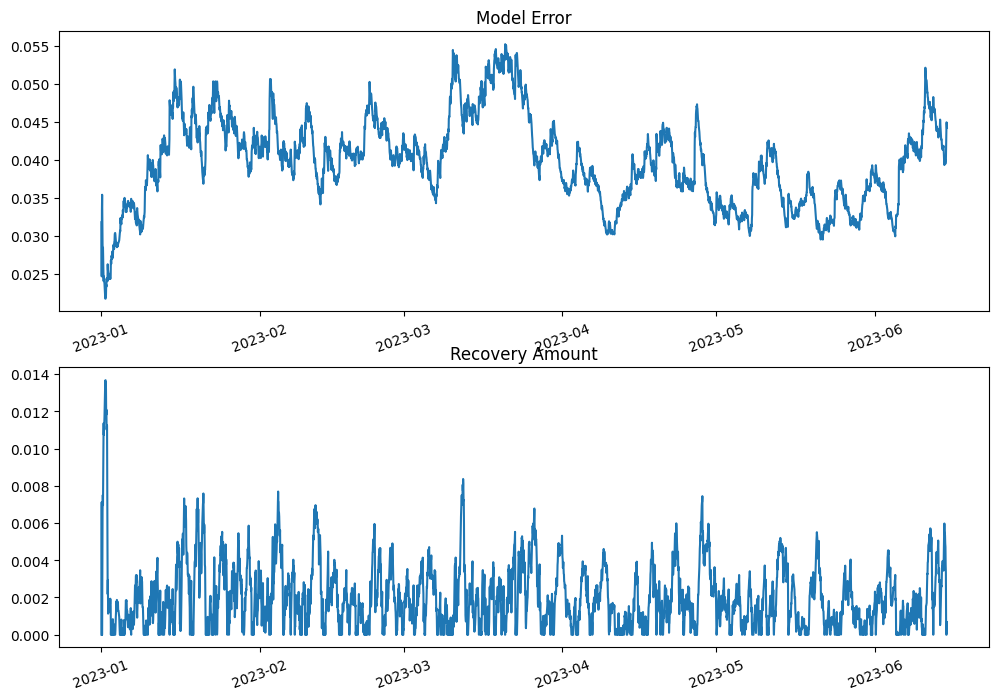

In [87]:
figs, axis = plt.subplots(2, figsize=(12,8))

axis[0].plot(absolute_mean_error)
axis[0].set_title("Model Error")
axis[0].tick_params(axis='x', rotation=20)

axis[1].plot(recovery_amt)
axis[1].set_title("Recovery Amount")
axis[1].tick_params(axis='x', rotation=20)

plt.show()

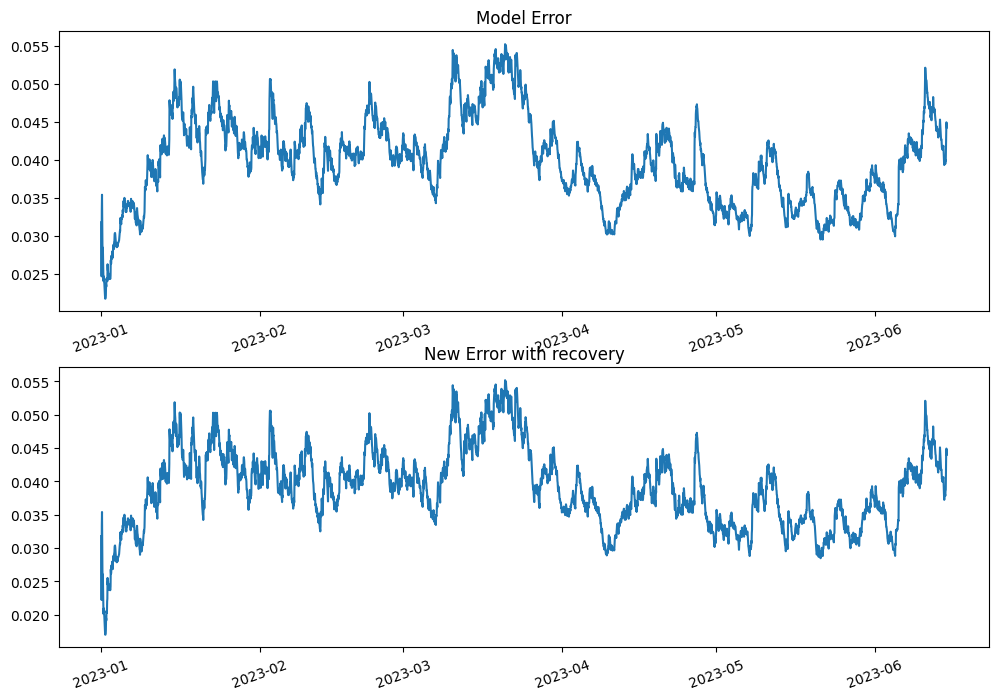

In [88]:
figs, axis = plt.subplots(2, figsize=(12,8))

axis[0].plot(absolute_mean_error)
axis[0].set_title("Model Error")
axis[0].tick_params(axis='x', rotation=20)

axis[1].plot(new_error)
axis[1].set_title("New Error with recovery")
axis[1].tick_params(axis='x', rotation=20)


plt.show()

In [11]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
warnings.filterwarnings("default")

In [89]:
max_holding = 0.1         
volume_max_turnover = 0.01
min_yearly_return = 0.3
min_portfolio_change = 0.23535660473711714
taker_fees = 0.00035 

lambda_0 = 5.703377699222638
alpha = 6239.537064589888

optimizer = PortfolioOptimizer(unique_coins, max_holding, volume_max_turnover, lambda_0, alpha, min_portfolio_change, min_yearly_return, taker_fees, 5, 24)
target_df = optimizer.generate_target_positions(1000000, predicted_returns, betas, volumes, funding_rates, resid_returns, factor_returns, factor_exposures, new_error, liquidity)

In [90]:
ba_df = liquidity.reset_index()
ba_df = ba_df.rename(columns={"date":"timestamp"})
funding_df = funding_rates.reset_index()

In [91]:
equity, trades, positions = backtest(1000000, target_df, ba_df, taker_fees, funding_df)

TICKER               1000LUNC  1000PEPE  1000SHIB       ADA      AGIX  \
timestamp                                                               
2023-01-01 01:00:00  0.000000    0.0000  0.000000  0.000000  0.000000   
2023-01-01 02:00:00  0.000000    0.0000  0.000000  0.000000  0.000000   
2023-01-01 03:00:00  0.000000    0.0000  0.000000  0.000000  0.000000   
2023-01-01 04:00:00  0.000000    0.0000  0.000000  0.000000  0.000000   
2023-01-01 05:00:00  0.000000    0.0000  0.000000  0.000000  0.000000   
...                       ...       ...       ...       ...       ...   
2023-06-15 20:00:00  0.000000    0.0000  0.000000  0.000000  0.000000   
2023-06-15 21:00:00  0.000000    0.0000  0.000000  0.000000  0.000000   
2023-06-15 22:00:00  0.000000    0.0000  0.000000  0.000000  0.000000   
2023-06-15 23:00:00  0.000000    0.0000  0.000000  0.000000  0.000000   
2023-06-16 00:00:00  0.000096    0.0001  0.000005 -0.000039  0.000035   

TICKER                  ALPHA      ANKR     APE   

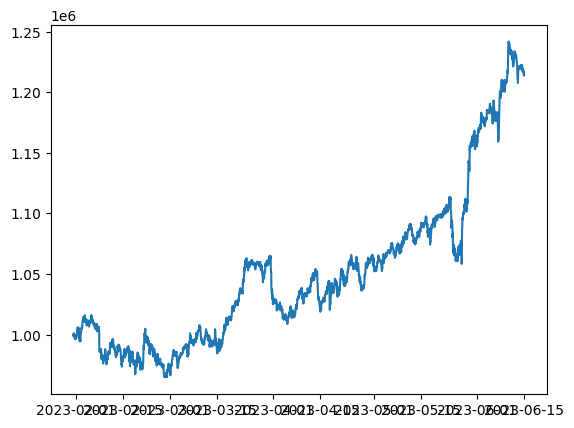

In [92]:
plt.plot(equity["portfolio_value"])

In [93]:
rets_bps = 10000.0 * pd.Series(equity["portfolio_value"][::24], index=equity.index[::24]).pct_change()
stats, daily_rets_bps, return_index, drawdown_bps, rolling_1yr_vol_bps = compounded_daily_return_stats(rets_bps)

In [94]:
stats

{'day_count                 ': 135,
 'daily_ret_mean       (bps)': np.float64(15.286903031472564),
 'daily_ret_std        (bps)': np.float64(97.41947614218184),
 'daily_ret_skew       (bps)': np.float64(-0.1562479800317452),
 'daily_ret_max        (bps)': np.float64(412.6061344470666),
 'daily_ret_min        (bps)': np.float64(-332.9453189758946),
 'annualized_ret       (bps)': np.float64(7166.664316410353),
 'monthly_geometic_ret (bps)': np.float64(460.61358537114126),
 'max_drawdown         (bps)': np.float64(-476.597667343922),
 'annual_ret/max_drawdown   ': np.float64(15.03713678740847),
 'sharpe                    ': np.float64(2.997920784462754),
 'sortino                   ': np.float64(4.095773144867315),
 'tot_compounded_ret   (bps)': np.float64(2212.4174113775075),
 'rolling_1yr_vol_mean (bps)': nan,
 'rolling_1yr_vol_min  (bps)': np.float64(nan),
 'rolling_1yr_vol_max  (bps)': np.float64(nan),
 'daily_ret_10th       (bps)': np.float64(-87.07295123465731),
 'daily_ret_25th   

In [ ]:
def backtest(AUM, target_df, ba_df, taker_fee, funding_df):
    target_df = target_df.copy()
    ba_df = ba_df.copy()
    funding_df = funding_df.copy()

    target_df['timestamp'] = pd.to_datetime(target_df['timestamp'])
    ba_df['timestamp'] = pd.to_datetime(ba_df['timestamp'])
    funding_df['timestamp'] = pd.to_datetime(funding_df['timestamp'])

    # Pivot targets to matrix: index=datetime, columns=ticker
    W = (target_df
         .pivot_table(index='timestamp', columns='TICKER', values='target', aggfunc='last')
         .sort_index()
         .fillna(0.0))
    
    # Quotes matrices
    bids = (ba_df.pivot_table(index='timestamp', columns='TICKER', values='bid_price', aggfunc='last')
                 .reindex(W.index).sort_index())
    asks = (ba_df.pivot_table(index='timestamp', columns='TICKER', values='ask_price', aggfunc='last')
                 .reindex(W.index).sort_index())
    
    mids = (bids + asks) / 2.0

    # Funding rates matrix
    funding_rates = funding_df.pivot_table(index='timestamp', columns='TICKER', values='funding_rate', aggfunc='last')

    # Align tickers and ffill quotes
    tickers = sorted(set(W.columns) & set(bids.columns) & set(asks.columns))

    W = W.reindex(columns=tickers).fillna(0.0)

    bids = bids.reindex(columns=tickers).ffill()
    asks = asks.reindex(columns=tickers).ffill()
    mids = mids.reindex(columns=tickers).ffill()
    funding_rates = funding_rates.reindex(columns=tickers).ffill()

    # State
    qty = pd.Series(0.0, index=tickers)
    cash = float(AUM)
    fees_cum = 0.0
    funding_pnl_cum = 0.0  # Cumulative funding PnL

    # Storage
    equity_rows, trades_rows, pos_rows = [], [], []
    for t in W.index:
        w = W.loc[t].fillna(0.0)
        bid = bids.loc[t]
        ask = asks.loc[t]
        mid = mids.loc[t]
        funding_rate = funding_rates.loc[t]  # Get funding rates at this time
        
        # Target quantities from constant AUM and mid price
        desired_dollars = AUM * w
        desired_qty = (desired_dollars / mid.replace(0, np.nan)).fillna(0.0)

        # Trade to target
        delta_qty = desired_qty - qty
        buy_mask = delta_qty > 0
        sell_mask = delta_qty < 0
        buy_qty = delta_qty.where(buy_mask, 0.0)
        sell_qty = (-delta_qty).where(sell_mask, 0.0)
        buy_notional = (buy_qty * ask).sum()
        sell_notional = (sell_qty * bid).sum()
        fees = taker_fee * (buy_notional + sell_notional)

        # Update cash and positions
        cash = cash - buy_notional + sell_notional - fees
        qty = qty + delta_qty
        fees_cum += fees

        # Funding rate effect on cash based on position size (positive or negative depending on long/short)
        funding_cost = (desired_dollars * funding_rate).sum()  # Funding impact based on positions
        cash -= funding_cost  # Deduct funding from cash (if long) or add (if short)
        
        # Cumulative funding PnL
        funding_pnl_cum -= funding_cost

        # Mark-to-market at mid
        port_value = cash + (qty * mid).sum()

        # Reporting
        turnover_notional = (abs(delta_qty) * mid).sum()
        equity_rows.append({
            'datetime': t,
            'portfolio_value': port_value,
            'cash': cash,
            'fees_cum': fees_cum,
            'turnover_notional': turnover_notional,
            'funding_pnl_cum': funding_pnl_cum  # Add cumulative funding PnL
        })

        # Trades log
        if buy_qty.sum() > 0:
            for k in tickers:
                q = float(buy_qty[k])
                if q > 0:
                    fp = float(ask[k])
                    fn = q * fp
                    trades_rows.append({
                        'datetime': t, 'ticker': k, 'trade_qty': q,
                        'fill_price': fp, 'fill_notional': fn, 'fee': taker_fee * fn
                    })

        if sell_qty.sum() > 0:
            for k in tickers:
                q = float(sell_qty[k])
                if q > 0:
                    fp = float(bid[k])
                    fn = q * fp
                    trades_rows.append({
                        'datetime': t, 'ticker': k, 'trade_qty': -q,
                        'fill_price': fp, 'fill_notional': fn, 'fee': taker_fee * fn
                    })

        # Positions snapshot
        snap = qty.copy()
        snap.name = t
        pos_rows.append(snap)

    equity = pd.DataFrame(equity_rows).set_index('datetime').sort_index()
    trades = pd.DataFrame(trades_rows)
    positions = pd.DataFrame(pos_rows)
    positions.index.name = 'datetime'
    positions.columns.name = 'ticker'

    # Convenience columns
    equity['pnl'] = equity['portfolio_value'].diff().fillna(0.0)
    equity['ret'] = equity['portfolio_value'].pct_change().fillna(0.0)
    
    return equity, trades, positions

In [ ]:
max_holding = 0.1
volume_max_turnover = 0.01
min_yearly_return = 0.3   
taker_fees = 0.00035

# Bayesian Hyperparameter tuning
def objective(trial):
    recovery_rate = trial.suggest_float('recovery_rate', 0, 2)
    lambda_0 = trial.suggest_float('lambda_0', 0, 50)
    alpha = trial.suggest_float('alpha', 0, 10000)
    min_portfolio_change = trial.suggest_float('min_portfolio_change', 0, 0.4)

    mean_error_df = index_prices.copy()
    mean_error_df["return"] = mean_error_df.groupby('TICKER')['index_price'].shift(-1) / index_prices['index_price'] - 1
    mean_error_df = mean_error_df[["TICKER", "return"]]

    mean_error_df = mean_error_df.merge(predicted_returns[["TICKER", "alpha_spec_ret_0_1"]], on=['timestamp', 'TICKER'], how='left').dropna()
    mean_error_df['abs_error'] = np.where(np.sign(mean_error_df['return']) != np.sign(mean_error_df['alpha_spec_ret_0_1']), 
                                                np.abs(mean_error_df['return'] - mean_error_df['alpha_spec_ret_0_1']),
                                                np.sqrt(np.abs(mean_error_df['return'] - mean_error_df['alpha_spec_ret_0_1']))) 

    absolute_mean_error = mean_error_df.groupby(mean_error_df.index.floor('h'))['abs_error'].mean().ewm(span=3*24).mean()
    recent_peak = absolute_mean_error.rolling(window=24, min_periods=1).max()
    recovery_amt = (recent_peak - absolute_mean_error).clip(lower=0)

    new_error = (absolute_mean_error-recovery_rate*recovery_amt).clip(lower=0)


    optimizer = PortfolioOptimizer(unique_coins, max_holding, volume_max_turnover, lambda_0, alpha, min_portfolio_change, min_yearly_return, taker_fees, 5, 24)
    target_df = optimizer.generate_target_positions(1000000, predicted_returns, betas, volumes, funding_rates, resid_returns, factor_returns, factor_exposures, new_error, liquidity)

    equity, trades, positions = backtest(1000000, target_df, ba_df, taker_fees, funding_df)

    rets_bps = 10000.0 * pd.Series(equity["portfolio_value"][::24], index=equity.index[::24]).pct_change()
    stats, daily_rets_bps, return_index, drawdown_bps, rolling_1yr_vol_bps = compounded_daily_return_stats(rets_bps) 

    sharpe = stats['sharpe                    ']   
    calmar = stats['annual_ret/max_drawdown   ']


    return 0.4 * sharpe/3 + 0.6*calmar/6


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=300)

print("Number of finished trials", len(study.trials))
print("Best trial:", study.best_trial.params)
print("Best Score:", study. best_trial.value)

[I 2025-08-10 21:44:33,054] A new study created in memory with name: no-name-adabd6fb-4049-498d-8061-643ea183d5fb


In [ ]:
# Continue Optimization
study.optimize(objective, n_trials=50)

print("Number of finished trials", len(study.trials))
print("Best trial:", study.best_trial.params)
print("Best Score:", study. best_trial.value)

NameError: name 'study' is not defined

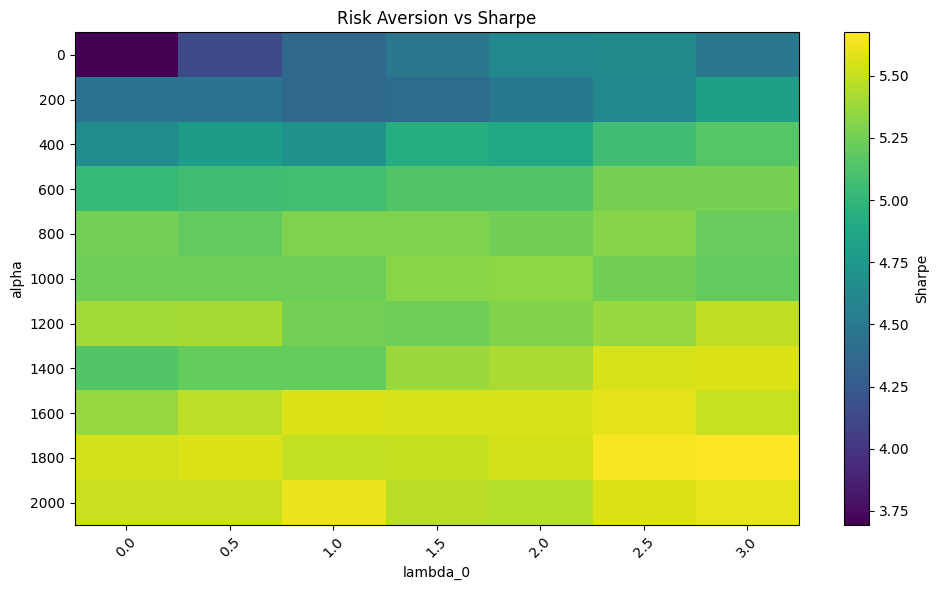

In [ ]:
lambda_vals = np.arange(0, 3.5, 0.5)  
alpha_vals = np.arange(0, 2200, 200)

a = np.array(lambdas[:-30])
b = np.array(alphas[:-30])
c = np.array(sharpes[:-30])

c_matrix = np.array(c).reshape(len(lambda_vals), len(alpha_vals)).T

# Plot heatmap
fig, ax = plt.subplots(figsize=(10, 6))
im = ax.imshow(c_matrix, cmap='viridis', aspect='auto')

# Set axis labels
ax.set_xticks(np.arange(len(lambda_vals)))
ax.set_yticks(np.arange(len(alpha_vals)))
ax.set_xticklabels(np.round(lambda_vals, 2))
ax.set_yticklabels(alpha_vals)
ax.set_xlabel('lambda_0')
ax.set_ylabel('alpha')
ax.set_title('Risk Aversion vs Sharpe')

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Sharpe')

# Rotate x-axis labels if needed
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()